In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-notebook')

import nltk
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
df = df.head(500)

## Quick EDA

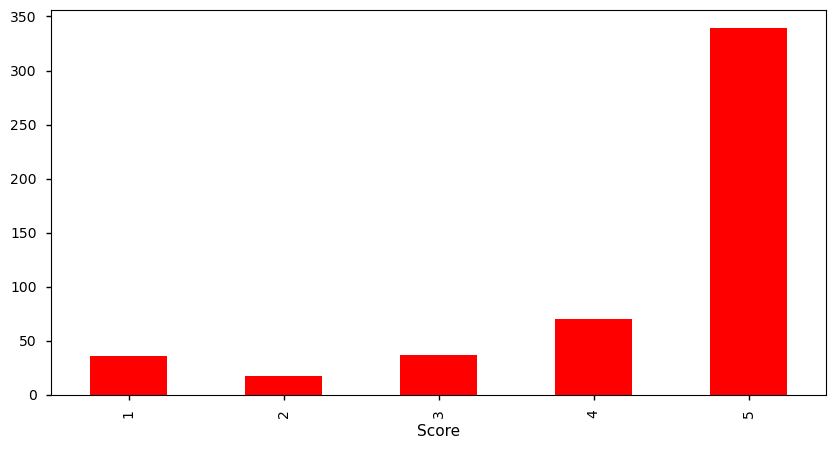

In [3]:
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', color = 'red',figsize = (10,5))
ax.set_xlabel('Score');

## Basic NLTK

In [4]:
example = df.Text[50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [5]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1 - VADER Sentiment Scoring
- Uses individuals words to give a score.
- Does not include context or relation between two words

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [9]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [10]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [11]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [12]:
res = {}
for i, row in tqdm(df.iterrows(),total = len(df)):
    text = row['Text']
    myId = row['Id']
    res[myId] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index' : 'Id'})
vaders = vaders.merge(df, how = 'left')

## Plotting Vaders results

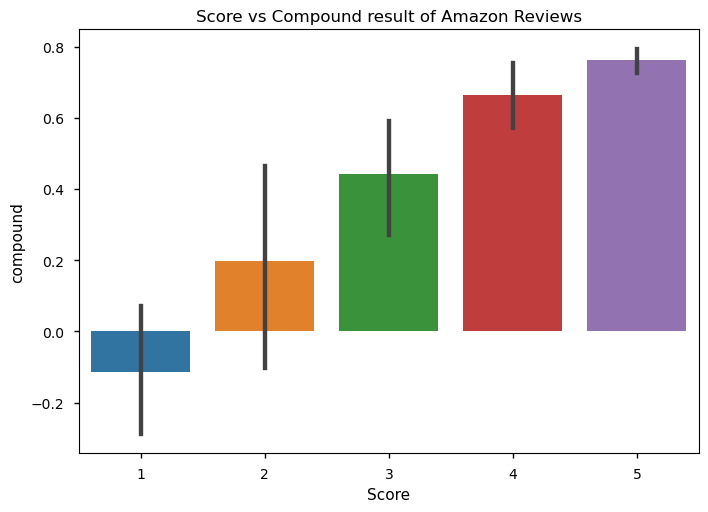

<Figure size 200x100 with 0 Axes>

In [14]:
ax = sns.barplot(vaders, x = 'Score', y = 'compound')
plt.figure(figsize = (2,1))
ax.set_title('Score vs Compound result of Amazon Reviews')
plt.show()

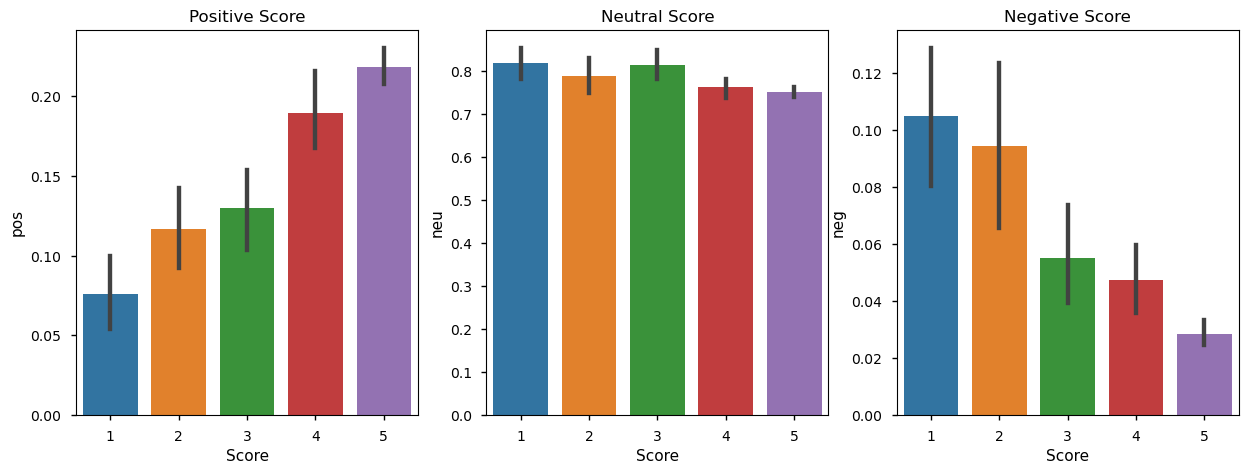

In [15]:
fig, axs = plt.subplots(1,3,figsize = (15,5))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg', ax = axs[2])

axs[0].set_title('Positive Score')
axs[1].set_title('Neutral Score')
axs[2].set_title('Negative Score')

plt.show()

# Step 2 : Roberta Pretrained Model
- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [16]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [18]:
# Vader Results
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [19]:
encoded_text = tokenizer(example,return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}

In [20]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example,return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict
    

In [21]:
res = {}
for i, row in tqdm(df.iterrows(),total = len(df)):
    try:
        text = row['Text']
        myId = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key,value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myId] = both
    except RuntimeError:
        print(f'Broke for id {myId}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [22]:
res[1]

{'vader_neg': 0.0,
 'vader_neu': 0.695,
 'vader_pos': 0.305,
 'vader_compound': 0.9441,
 'roberta_neg': 0.009624232,
 'roberta_neu': 0.04998039,
 'roberta_pos': 0.9403955}

In [23]:
result_df = pd.DataFrame(res).T
result_df = result_df.reset_index().rename(columns = {'index' : 'Id'})
result_df = result_df.merge(df, how = 'left')

In [24]:
result_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Combine and Compare

In [25]:
result_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

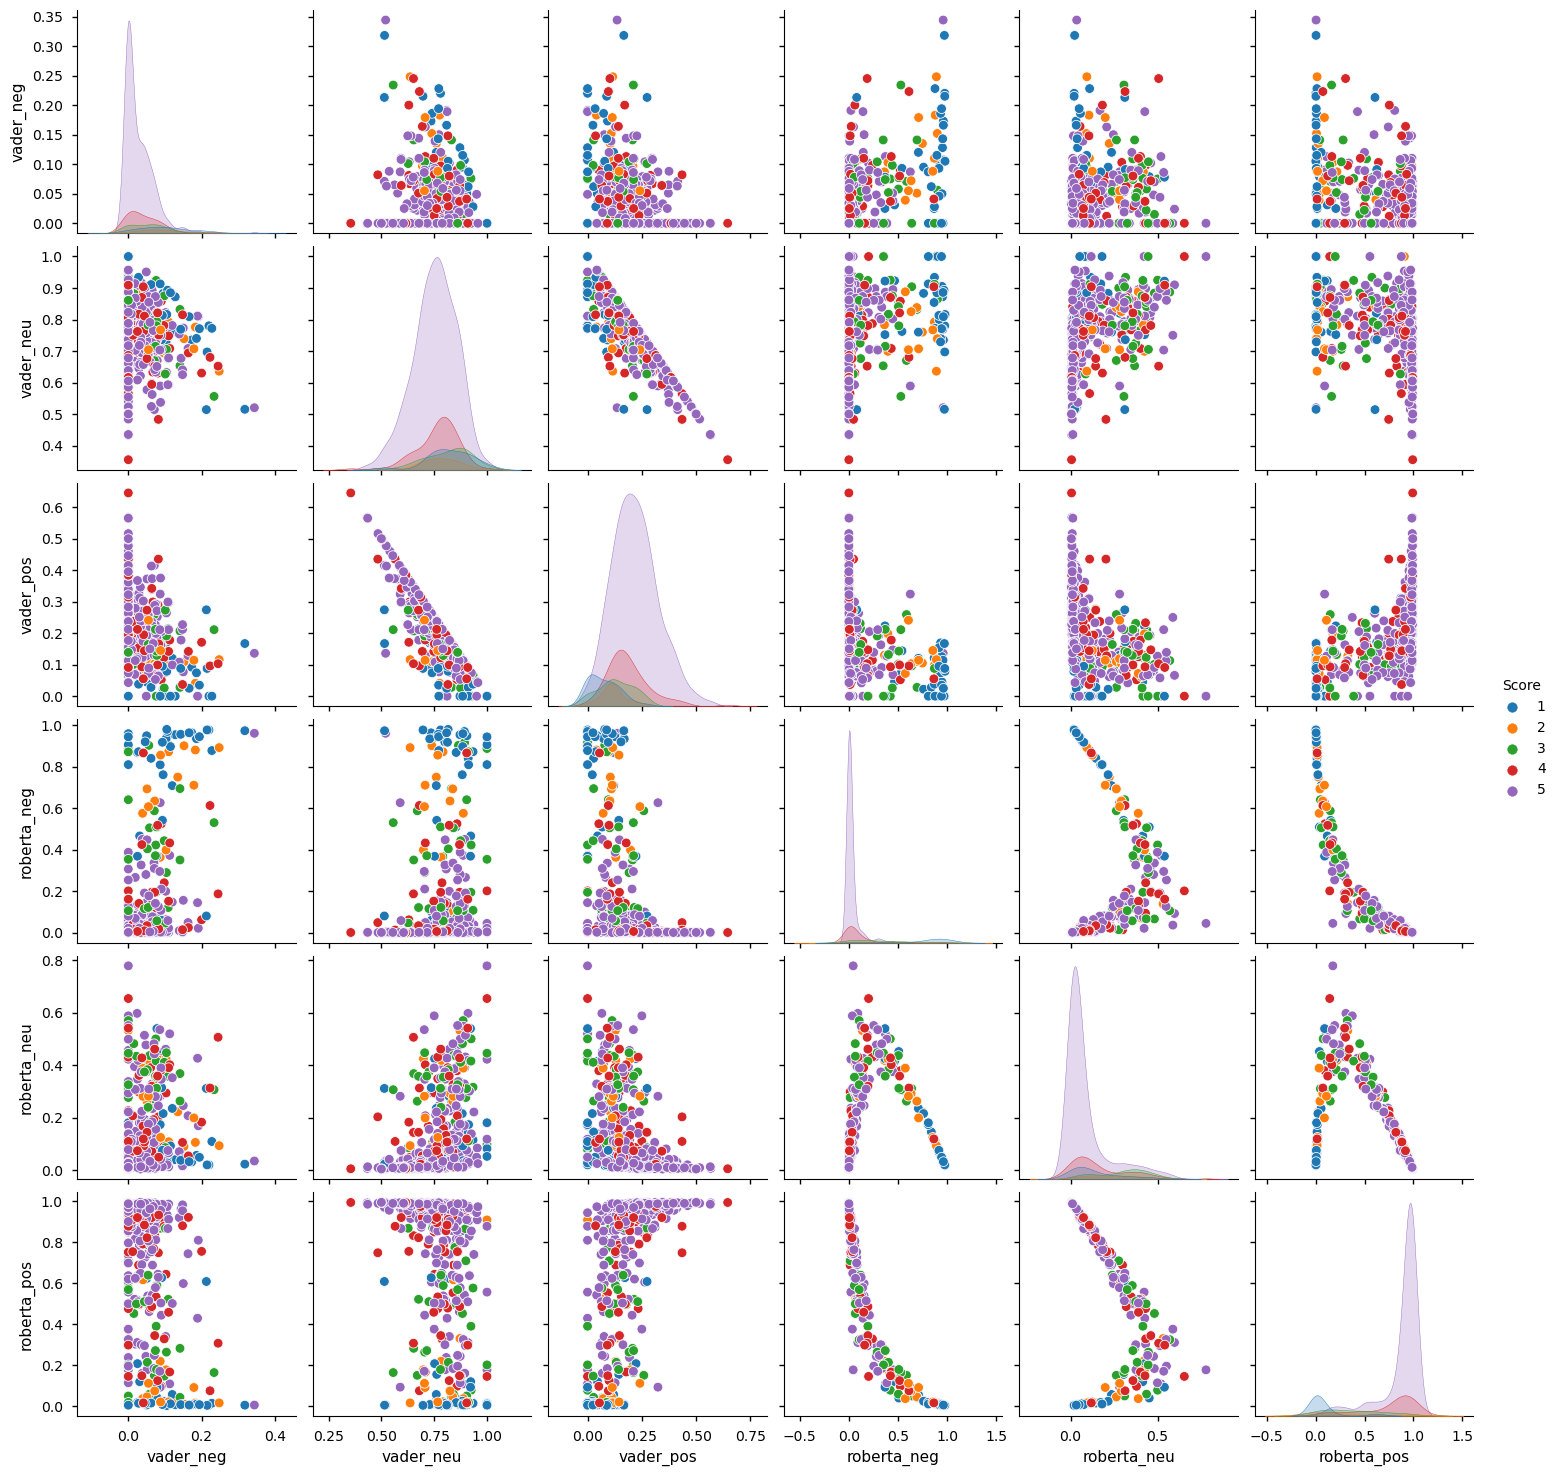

In [26]:
sns.pairplot(data = result_df,
            vars = ['vader_neg', 'vader_neu', 'vader_pos',
                   'roberta_neg', 'roberta_neu', 'roberta_pos'], 
            hue = 'Score',
            palette = 'tab10')
plt.show()

## Review Examples

In [27]:
# review examples with score of 1 but model gave a positive outcome
print(result_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0])
print(" ")
print(result_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0])

I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.
 
So we cancelled the order.  It was cancelled without any problem.  That is a positive note...
